## Optimizer Examples
I've made some optimizer classes to speed up the cycle rep and bounding chain optimization process. Here, I give examples for how to use them.

<div class="alert alert-block alert-danger">
Everything in the files right now is subject to change. Currently, I only have plans to modify the backend, not the API, but that may change in the future.
</div>

### Preliminaries

In [1]:
# load some packages
import Gavin.utils.optimizers as op
import matplotlib.pyplot as plt
import oatpy as oat
import numpy as np

## Point Set
Here's the point set we'll be finding cycles/bounding chains on.

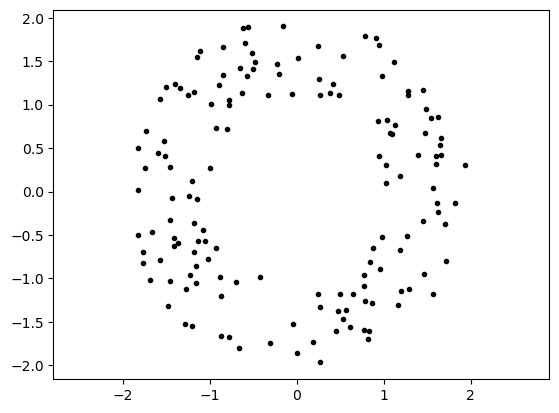

In [2]:
pts = oat.point_cloud.annulus(150, 1, 2, random_seed=10) # create point set

plt.axis('equal')
plt.plot(pts[:, 0], pts[:, 1], 'k.')

### Homology
The optimizer works from an `OAT` `FactoredBoundaryMatrixVr` object. Therefore, before you try to do any cycle optimization, you should find this.

Technically, you don't need homology too, but optimization works off of birth simplicies so you need some whay of getting those.

In [3]:
enclosing = oat.dissimilarity.enclosing_from_cloud(pts) + 1e-10 # distance after which theres no homology
dissimilairty_matrix = oat.dissimilarity.matrix_from_cloud( # distance matrix
        cloud=pts,
        dissimilarity_max=enclosing
    )
factored = oat.rust.FactoredBoundaryMatrixVr(
        dissimilarity_matrix=dissimilairty_matrix,
        homology_dimension_max=2
    )
homology = factored.homology( # solve homology
        return_cycle_representatives=True, # These need to be true to be able to make a barcode
        return_bounding_chains=True
    )

### Cycle We'll Focus On
We're going to focus on the main cycle in the annulus, which is the last of the dimension 1 cycles to die.

The initial cycle is messy and doesn't really follow the shape we're looking for. Let's see what we can do about that!

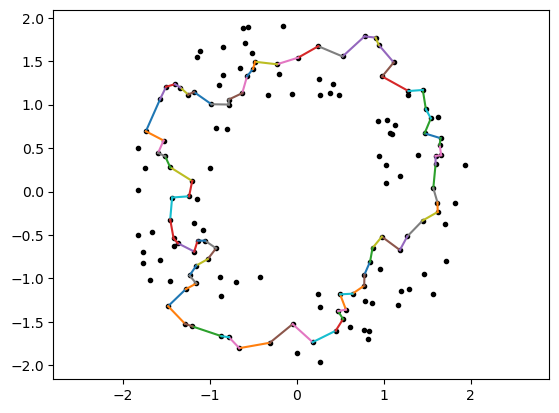

In [4]:
# identify the cycle
cycle_i = homology[(homology['dimension'] == 1)
                    & (homology['death'] == homology[homology['dimension'] == 1]['death'].max())
                    ].index[0]

# plot the initial (unoptimized) cycle rep
plt.axis('equal')
plt.plot(pts[:, 0], pts[:, 1], 'k.')
for s in homology.loc[cycle_i, 'cycle representative']['simplex']:
    plt.plot(pts[s, 0], pts[s, 1])

### Basic Optimization
To optimize a cycle, we have a couple options from the `CycleOptimizer` class. The simplest is to use the static `optimize_a_cycle` method. This is slow, since it doesn't use any setup from before and does all of it within the method, but is a good option if you just want to optimize one cycle. We can see, it returns a much tighter cycle than the initial one.

The method takes a birth simplex and a factored boundary matrix and returns a dataframe with the optimized cycle simplicices, filtration values, and coefficients (or orientations). It also takes the same optional arguments as the `CycleOptimizer` init and `optimize_cycle` method, which will be discussed later.

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2531206
Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 505 rows, 1365 columns and 2612 nonzeros
Model fingerprint: 0x1e259154
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 356 rows and 375 columns
Presolve time: 0.00s
Presolved: 149 rows, 990 columns, 2668 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     137    1.1097443e+01   0.000000e+00   

,simplex,filtration,coefficient
0,"[64, 139]",0.092418,1.0
1,"[40, 125]",0.163010,-1.0
2,"[9, 129]",0.178119,-1.0
3,"[38, 134]",0.185865,1.0
4,"[4, 109]",0.189650,-1.0
5,"[62, 93]",0.215881,1.0
6,"[56, 74]",0.247211,-1.0
7,"[31, 104]",0.253982,1.0
8,"[129, 135]",0.254188,-1.0
9,"[65, 128]",0.255026,-1.0


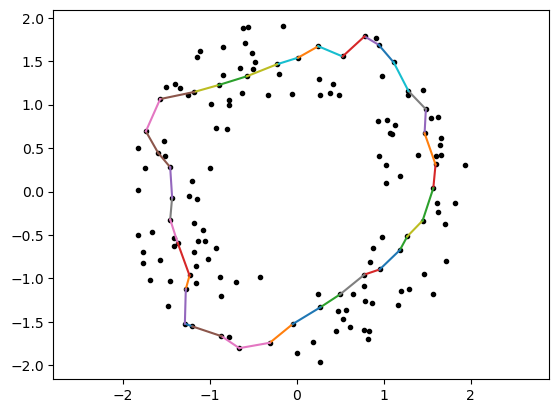

In [5]:
# optimize the cycle
optimized_cycle = op.CycleOptimizer.optimize_a_cycle(homology.loc[cycle_i, 'birth simplex'], factored)

# plot the optimal cycle rep
plt.axis('equal')
plt.plot(pts[:, 0], pts[:, 1], 'k.')
for s in optimized_cycle['simplex']:
    plt.plot(pts[s, 0], pts[s, 1])

optimized_cycle

### Optimizer Object
If you plan to optimize multiple cycles from the same simplcial complex, I suggest using a `CycleOptimizer` object instead of the static method. It can take a long time to setup, but ss much faster for optimizing individual cycles, since when you initialize the object most of the setup gets done and can be skipped later.

To initialize the object, you need to pass a factored boundary matrix and a cycle dimension, since it can't infer it from the birth simplex. You can also optionally set the default
- ProblemType: The default LP used to solve the problem. Can choose between the options in the `ProblemType` enum.
- Cost: The default cost vector. Can choose between the options in the `Cost` enum.
- Basis: The basis used to solve the problem. One option (Cycle-Boundary) is faster to initialize but the other option is faster to solve LPs for (Jordan). Can choose options using the `Basis` enum.
- Supress Gurobi: Turns off Gurobi output

Once you have the object, you can use the `optimize_cycle` command, which will optimize a cycle at birth given a birth simplex. Has the optional arguments
- Filtration: the filtration value to optimize the cycle at. Should be set between the birth and death time of the cycle (though could be after the death ig, it just wouldn't mean anything). If not set, uses the birth time of the cycle
- Return Objective: set this to true if you want a tuple with the cycle and the cost of the cycle. Otherwise, just returns the cycle dataframe
- Problem and Cost: Same as for the object. If not set, uses the objects default.


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2531206
Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 505 rows, 1365 columns and 2612 nonzeros
Model fingerprint: 0x1e259154
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 356 rows and 375 columns
Presolve time: 0.00s
Presolved: 149 rows, 990 columns, 2668 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     137    1.1097443e+01   0.000000e+00   

,simplex,filtration,coefficient
0,"[64, 139]",0.092418,1.0
1,"[40, 125]",0.163010,-1.0
2,"[9, 129]",0.178119,-1.0
3,"[38, 134]",0.185865,1.0
4,"[4, 109]",0.189650,-1.0
5,"[62, 93]",0.215881,1.0
6,"[56, 74]",0.247211,-1.0
7,"[31, 104]",0.253982,1.0
8,"[129, 135]",0.254188,-1.0
9,"[65, 128]",0.255026,-1.0


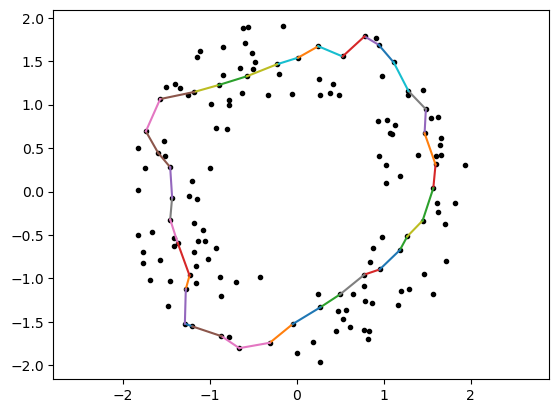

In [6]:
# intitialize the object
cycle_optimizer = op.CycleOptimizer(factored, 1)

# otpimze a cycle
optimized_cycle = cycle_optimizer.optimize_cycle(homology.loc[cycle_i, 'birth simplex'])

# plot the optimal cycle rep
plt.axis('equal')
plt.plot(pts[:, 0], pts[:, 1], 'k.')
for s in optimized_cycle['simplex']:
    plt.plot(pts[s, 0], pts[s, 1])

optimized_cycle

In [7]:
%%timeit
cycle_optimizer.optimize_cycle(homology.loc[cycle_i, 'birth simplex'])

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 505 rows, 1365 columns and 2612 nonzeros
Model fingerprint: 0x1e259154
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 356 rows and 375 columns
Presolve time: 0.00s
Presolved: 149 rows, 990 columns, 2668 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     137    1.1097443e+01   0.000000e+00   0.000000e+00      0s

Solved in 137 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.109744339e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Dar

In [8]:
%%timeit
op.CycleOptimizer.optimize_a_cycle(homology.loc[cycle_i, 'birth simplex'], factored)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 505 rows, 1365 columns and 2612 nonzeros
Model fingerprint: 0x1e259154
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 356 rows and 375 columns
Presolve time: 0.00s
Presolved: 149 rows, 990 columns, 2668 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     137    1.1097443e+01   0.000000e+00   0.000000e+00      0s

Solved in 137 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.109744339e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Dar

### Later Optimization
We can optimize cycles at other filtrations to see how the cycle evolves over time. To do this, just set the filtration parameter in the `optimize_cycle` method.

As time goes on, we can see the cycle gets tighter.

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 505 rows, 1365 columns and 2612 nonzeros
Model fingerprint: 0x1e259154
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 356 rows and 375 columns
Presolve time: 0.00s
Presolved: 149 rows, 990 columns, 2668 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     137    1.1097443e+01   0.000000e+00   0.000000e+00      0s

Solved in 137 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.109744339e+01
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Dar

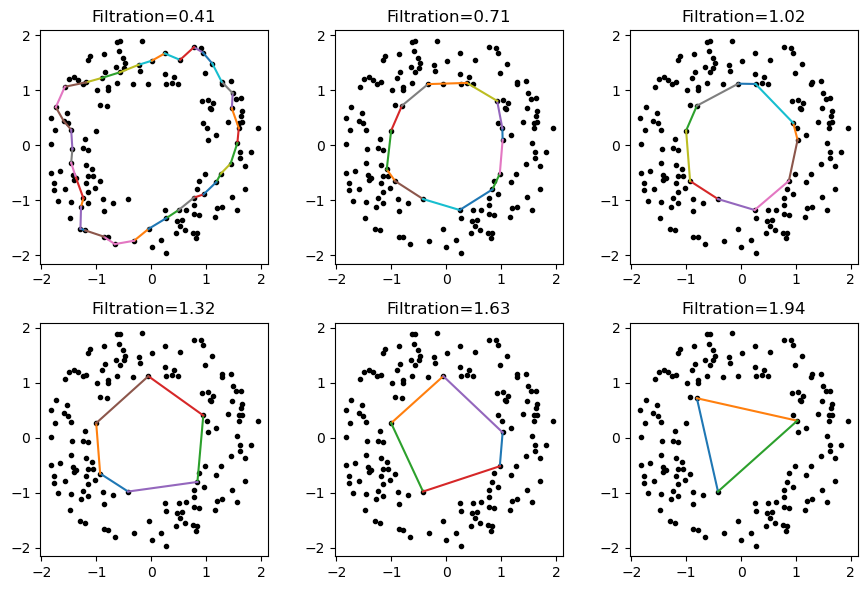

In [9]:
# filtrations we find cycles at
filtrations = np.linspace(homology.loc[cycle_i, 'birth'], homology.loc[cycle_i, 'death'], 6)

# plot setup
fig, ax = plt.subplots(2, 3)
fig.set_figwidth(9)
fig.set_figheight(6)
for i in range(ax.size):
    ax.take(i).set_aspect('equal')
    ax.take(i).plot(pts[:, 0], pts[:, 1], 'k.')

# plot cycles
for i, f in enumerate(filtrations):
    c = cycle_optimizer.optimize_cycle(homology.loc[cycle_i, 'birth simplex'], f)

    ax.take(i).set_title(f'Filtration={f:.2f}')
    for s in c['simplex']:
        ax.take(i).plot(pts[s, 0], pts[s, 1])

fig.tight_layout()

### Bounding Chains
Once you have a cycle dataframe, you can pass it to a bounding chain optimizer to find an optimal bounding chain. These have (more or less) the same options as the cycle optimizer and the same two options to optimize cycles (A static method for a couple cycles or an initialized object for finding many cycles).

You should also pass a death parameter to the function. This is technically optional, but if skipped it will possibly to return a bounding chain that closes after the cycle dies. This could be fixed by first solving an infinity norm minimization problem to find when the cycle dies, but I don't think that's worth it.

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M1 Max
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Academic license 2531206 - for non-commercial use only - registered to ge___@macalester.edu
Optimize a model with 4728 rows, 145184 columns and 435552 nonzeros
Model fingerprint: 0x1472595d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-02, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 45 rows and 0 columns
Presolve time: 0.37s
Presolved: 4683 rows, 145184 columns, 430880 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.17s

Barrier statistics:
 AA' NZ     : 2.132e+05
 Factor NZ  : 3.298e+06 (roughly 90 MB of memory)
 Factor Ops : 2.739e+09 (less than 1 second per iteration)
 Threads    : 8

                  Objective                Residual
Iter  

,simplex,filtration,coefficient
0,"[9, 129, 135]",0.428405,-1.0
1,"[4, 79, 109]",0.436076,1.0
2,"[56, 64, 139]",0.445134,1.0
3,"[9, 38, 134]",0.496049,1.0
4,"[65, 66, 79]",0.512323,1.0
5,"[17, 51, 94]",0.520707,1.0
6,"[31, 78, 104]",0.529838,-1.0
7,"[62, 93, 104]",0.538848,1.0
8,"[40, 125, 139]",0.556752,-1.0
9,"[8, 56, 74]",0.561229,-1.0


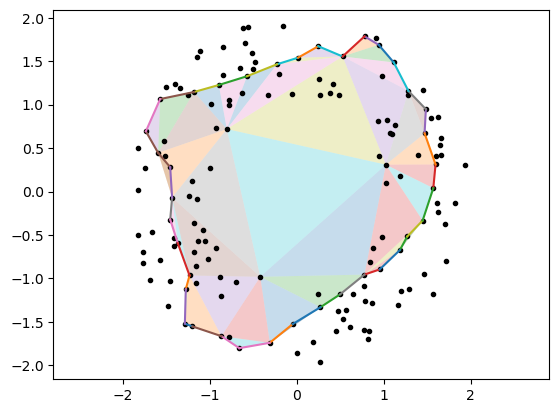

In [10]:
# find the bounding chain
optimized_bounding_chain = op.BoundingChainOptimizer.optimize_a_bounding_chain(optimized_cycle, factored, death=homology.loc[cycle_i, 'death'])

# setup the plot
plt.axis('equal')
plt.plot(pts[:, 0], pts[:, 1], 'k.')

# plot the cycle rep
for s in optimized_cycle['simplex']:
    plt.plot(pts[s, 0], pts[s, 1])

# plot the bounding chain
for s in optimized_bounding_chain['simplex']:
    plt.fill(pts[s, 0], pts[s, 1], alpha=0.25)

optimized_bounding_chain

### A Final Note
Theoretically, everything here works in any dimension. It hasn't been tested tho so idk that for sure.